In [1]:
import requests
import json
import pandas as pd
from flatten_json import flatten
from utils.io import dict_to_yaml, yaml_to_dict

id = "lgulden"
apikey = "4d1a4bc3be920e859b3862a25d3725d741028d42"
data_gov_api_key = "n4TEYUedn3STcnsxQi7JllzXZgfB6Dqg5pV2068E"
%load_ext jupyter_black

In [110]:
df_list = []
for i in range(1, 17):
    df_list.append(
        pd.read_csv(
            f"/Volumes/Samsung_T5/data/lobbying/tmp/ccs_lda_filings_{i}.csv",
            index_col=[0],
            # parse_dates=["filing_dt_posted"],
            dtype={"filing_year": int},
        )
    )

ccs_df = pd.concat(df_list)

/var/folders/lt/m2fk6lx14jgb93y6x53z12q00000gn/T/ipykernel_1160/2877718890.py:4: DtypeWarning: Columns (275) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/folders/lt/m2fk6lx14jgb93y6x53z12q00000gn/T/ipykernel_1160/2877718890.py:4: DtypeWarning: Columns (275) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


In [111]:
def get_list_govt_entities(entity_endpoint: str, session: object):
    """Queries constants endpoint to get a standardized list of government entities"""
    govt_entities = session.get(entity_endpoint, timeout=60)
    entity_df = pd.DataFrame(govt_entities.json())
    entities = sorted([x.lower() for x in list(entity_df["name"])])
    return entities


def api_authenticate(
    authentication_endpoint,
    username,
    apikey,
    username_key="username",
    password_key="password",
):
    """logs in to the api using provided authentication endpoint and credentials"""
    authenticated_session = requests.Session()

    authenticated_session.post(
        authentication_endpoint,
        json={
            username_key: username,
            password_key: apikey,
        },
        timeout=60,
    )

    return authenticated_session


lda_apikey = "b6c22528b6697dc3bf1fbf9ff5200d28d9991889"
lda_username = "lindseyegulden"
entities = get_list_govt_entities(
    "https://lda.senate.gov/api/v1/constants/filing/governmententities/",
    session=api_authenticate(
        "https://lda.senate.gov/api/auth/login/", lda_username, lda_apikey
    ),
)
entities_revised = [col for col in ccs_df.columns.values if col in entities]
ccs_df[entities_revised] = ccs_df[entities_revised].fillna(0)

In [112]:
entities_influenced = ccs_df[entities_revised].sum()
zeroed = list(entities_influenced[entities_influenced == 0].index)
ccs_df = ccs_df[[x for x in ccs_df.columns.values if x not in zeroed]].copy()
entities_revised = list(entities_influenced[entities_influenced != 0].index)

# get a list of the non-entity columsn
non_entity_cols = list(
    ccs_df[ccs_df.columns.difference(entities_revised)].columns.values
)

# remove unwanted filing types
ccs_df = ccs_df.loc[[x[0] != "R" for x in ccs_df.filing_type]]

In [113]:
import re
from cleanco import basename

starting_client_names = sorted(list(ccs_df.client_name.unique()))
client_names = sorted(list(ccs_df.client_name.unique()))
client_names = [
    basename(re.sub(r"[^\w\s]", "", company_name)) for company_name in client_names
]

client_names = [x.split("ON BEHALF OF")[-1] for x in client_names]
# client_names = [x.split(" (FKA")[0] for x in client_names]
# client_names = [x.split(" FKA")[0] for x in client_names]
for n in [
    " CORPORATION",
    " LLC",
    " FKA",
    " VENTURES",
    " NORTH AMERICA",
    " LONDON",
    " USA",
    "FORMERLY KNOWN AS",
    "FORMERLY",
    " (FKA",
]:
    client_names = [x.split(n)[0] for x in client_names]

for n in ["SERVICES", "THE ", "COMPANY", "INC", "GROUP", "CRES", "NRECA", "INFORMAL"]:
    client_names = [x.replace(n, "") for x in client_names]
client_names = [x.replace("  ", " ") for x in client_names]
client_names = [x.rstrip().lstrip() for x in client_names]
# Bespoke replacements
for key, value in {
    "MUNCIPAL": "MUNICIPAL",
    "DEPT": "DEPARTMENT",
    "ASSOCCIATION": "ASSOCIATION",
    "ISG ON BEHHALF OF": "USA BIOMASS POWER PRODUCERS ALLIANCE",
    "SIGLOBAL": "SITHE GLOBAL",
    "SOUTHERN CALIFORNIA EDISON": "EDISON INTERNATIONAL",
    "GALLAGHER FINANCIAL": "GALLAGHER",
}.items():
    client_names = [x.replace(key, value) for x in client_names]

# BESPOKE REPLACEMENTS
for co in [
    "EXXON",
    "MARATHON",
    "SHELL",
    "CHEVRON",
    "DENBURY",
    "DOMINION",
    "DOW",
    "DUKE",
    "TOTAL",
    "AMERICAN ELECTRIC POWER",
    "BABCOCK WILCOX",
    "CONSTELLATION ENERGY",
    "LINDE",
    "SASOL",
    "HOLCIM",
    "NEXTERA",
    "PORTLAND CEMENT ASSOCIATION",
    "SEMPRA",
    "SIEMENS",
    "TALLGRASS",
    "TECO",
    "GREAT PLAINS INSTITUTE",
    "TOYOTA",
    "VISTRA",
    "ALSTOM",
    "ZURICH",
    "ALLETE",
    "BATTELLE",
    "BIOMASS POWER ASSOCIATION",
    "PRAIRIE STATE GENERATING",
    "PEABODY",
    "MITSUBISHI",
    "FORTESCUE"
    # "CHAMBER OF COMMERCE",
]:
    client_names = [co if co in x else x for x in client_names]

merger_dict = {
    "AVANGRID": "UIL-AVANGRID",
    "UIL HOLDINGS": "UIL-AVANGRID",
    "ALLETE": "ALLETE-ENERGYFORWARD",
    "ENERGY FORWARD": "ALLETE-ENERGYFORWARD",
    "ALSTOM": "GE-ALSTOM",
    "GE ENERGY": "GE-ALSTOM",
    "GENERAL ELECTRIC LUDING SUBSIDIARIES": "GE-ALSTOM",
    "SANDRIDGE-ALSTOM": "SANDRIDGE ENERGY",  # correct error
    "TC ENERGY": "TRANSCANADA-TC ENERGY",
    "TRANSCANADA PIPELINES": "TRANSCANADA-TC ENERGY",
    "CONSTELLATION ENERGY": "EXELON-CONSTELLATION-PEPCO",
    "EXELON BUSINESS": "EXELON-CONSTELLATION-PEPCO",
    "SVANTE": "INVENTYS-SVANTE",
    "INVENTYS THERMAL TECHNOLOGIES DBA SVANTE": "INVENTYS-SVANTE",
    "TESORO": "MARATHON-TESORO",
    "MARATHON": "MARATHON-TESORO",
    "MARATHON-MARATHON-TESORO": "MARATHON-TESORO",
    "MARATHON-TESORO-TESORO": "MARATHON-TESORO",
    "ECOLAB": "ECOLAB-NALCO",
    "NALCO": "ECOLAB-NALCO",
    "ECOLAB-ECOLAB-NALCO": "ECOLAB-NALCO",
    "ECHENEIDAE DBA REMORA": "REMORA",
    "M M ENERGY": "MM ENERGY",
    "QURATE RETAIL": "LIBERTY-QURATE",
    "LIBERTY MEDIA": "LIBERTY-QURATE",
    "MIRANT": "NRG-RRI-MIRANT-GENON",
    "GENON ENERGY": "NRG-RRI-MIRANT-GENON",
    "RRI ENERGY": "NRG-RRI-MIRANT-GENON",
    "NRG ENERGY": "NRG-RRI-MIRANT-GENON",
    "SOO LINE RAILROAD DBA CANADIAN PACIFIC RAILWAY": "CANADIAN PACIFIC RAILWAY",
    "DELAWARE AND HUDSON RAILWAY DBA CANADIAN PACIFIC RAILWAY": "CANADIAN PACIFIC RAILWAY",
    "CHAMBER OF COMMERCE OF THE": "US CHAMBER OF COMMERCE",
    "PEPCO HOLDINGS": "EXELON-CONSTELLATION-PEPCO",
    "PLASTIC POLLUTION COALITION A FISCALLY SPONSORED PROJECT OF EARTH ISLAND INSTIT": "PLASTIC POLLUTION COALITION",
    "ALCALDE FAY MM ENERGY": "MM ENERGY",
    "AMERICAN FOREST AND PAPER ASSOCIATION": "AMERICAN FOREST PAPER ASSOCIATION",
    "GREAT POINT ENERGY": "GREATPOINT ENERGY",
    'GDF SUEZ ENERGY':'ENGIE',
    'CATF ACTION':'CLEAN AIR TASK FORCE',
    'INVENTYS THERMAL TECHNOLOGIES DBA INVENTYS-SVANTE':'INVENTYS-SVANTE',
    'CLEAN ENERGY STRATEGYMJBA COALITIONS':'MJBA COALITIONS',
    'AUSTIN ENERGYCITY OF AUSTIN TEXAS':'AUSTIN ENERGY',
}
for key, value in merger_dict.items():
    client_names = [x.replace(key, value) for x in client_names]
print(len(client_names))
print(len(sorted(list(set(client_names)))))
client_name_rename_dict = dict(zip(starting_client_names, client_names))
ccs_df["client_rename"] = [client_name_rename_dict[x] for x in ccs_df.client_name]

656
519


In [114]:
# get the latest filing
import datetime as dt

ccs_df["filing_dt_posted"] = [
    dt.datetime.fromisoformat(d) for d in ccs_df["filing_dt_posted"]
]

ccs_df.sort_values(by="filing_dt_posted", ascending=False, inplace=True)

ccs_df = (
    ccs_df.groupby(
        [
            "filing_year",
            "filing_period",
            "client_id",
            "registrant_id",
            "activity_id",
        ]
    )
    .first()
    .reset_index()
)

In [115]:
def terms_present(phrase, term_list):
    """utility function to see if terms in terms_list are present in a given phrase
    Args:
        phrase: phrase to be searched
        term_list: list of strings to be searched for within phrase
    Returns:
        int: 1 if one or more of the terms are present in phrase, 0 otherwise
    """
    if phrase is None:
        return 0
    for term in term_list:
        if str(term).lower() in str(phrase).lower():
            return 1
    return 0

In [116]:
import re
from cleanco import basename

df = ccs_df.copy(deep=True)
df["clean_description"] = df["description"].fillna("").copy()
df["clean_description"] = [
    basename(re.sub(r"[^\w\s]", "", description))
    for description in df["clean_description"]
]

In [117]:
ccs_bill_dict = dict(zip(list(range(106, 119)), [{}] * len(list(range(106, 119)))))

ccs_bill_dict[118]["HR"] = [
    8820,
    8790,
    8491,
    7797,
    7571,
    6665,
    6622,
    6175,
    5744,
    5457,
    4877,
    4038,
    3792,
    3690,
    3892,
    3182,
    2811,
    2664,
    1562,
    1262,
    1,
]
ccs_bill_dict[118]["SB"] = [
    4406,
    3422,
    2812,
    2641,
    2599,
    1720,
    1576,
    542,
    458,
    429,
    5205,
    1923,
    1399,
    542,
    458,
    429,
]
ccs_bill_dict[118]["HA"] = list(range(133, 160))

ccs_bills = ["HR" + str(x) for x in ccs_bill_dict[118]["HR"]] + [
    "SB" + str(x) for x in ccs_bill_dict[118]["SB"]
]

In [118]:
df["sustainable"] = [
    terms_present(x, ["sustainable", "sustainability"]) for x in df.clean_description
]
df["permitting"] = [
    terms_present(x, ["permit", "permitting", "permits"]) for x in df.clean_description
]
df["carbon tax"] = [
    terms_present(x, ["carbon tax", "tax on carbon"]) for x in df.clean_description
]
df["recycle"] = [
    terms_present(x, ["recycle", "recycling"]) for x in df.clean_description
]
df["hydrogen"] = [terms_present(x, ["hydrogen"]) for x in df.clean_description]
df["carbon_management"] = [
    terms_present(x, ["carbon management"]) for x in df.clean_description
]
df["clean_energy"] = [terms_present(x, ["clean energy"]) for x in df.clean_description]
df["ethanol"] = [
    terms_present(x, ["ethanol", "bioethanol", "biofuels"])
    for x in df.clean_description
]
df["climate"] = [terms_present(x, ["climate"]) for x in df.clean_description]
df["energy security"] = [
    terms_present(x, ["energy security"]) for x in df.clean_description
]

df["low_carbon"] = [
    terms_present(x, ["low carbon", "low emissions", "low emission"])
    for x in df.clean_description
]
df["direct air"] = [
    terms_present(x, ["directair", "direct air", "air capture"])
    for x in df.clean_description
]
df["coal"] = [terms_present(x, ["coal"]) for x in df.clean_description]
df["clean coal"] = [terms_present(x, ["clean coal"]) for x in df.clean_description]
df["ccs_description"] = [
    terms_present(
        x,
        [
            w.replace("-", "")
            for w in [
                "clean coal",
                "carbon removal and sequestration",
                "carbon dioxide sequestration",
                "National Carbon Dioxide Storage Capacity Assessment Act",
                "carbon capture",
                "carbon sequestration",
                "co2 capture",
                "c02 capture",
                "co2 sequestration",
                "c02 sequestration",
                "carbon dioxide capture",
                "capture and store",
                "capture and storage",
                "capture transportation and storage",
                "capture transport and storage",
                "capture transport utilization and storage",
                "capture transport use and storage",
                "capture transport use and sequestration",
                "capture transport utilization and sequestration",
                "capture transport and store",
                "capture of carbon dioxide",
                "geologic sequestration",
                "geologic storage",
                "capture of co2",
                "capture of c02",
                "hydrogen hub",
                "hydrogen hubs",
                "clean hydrogen",
                "hydrogen",
                "greenhouse",
                "blue hydrogen",
                "capture and sequestration",
                "capture utilization and sequestration",
                "capture use and storage",
                "capture use and sequestration",
                "CCS",
                "CCUS",
                "45Q",
                "45V",
                "enhanced oil recovery",
                "EOR",
                "carbon management",
                # "low carbon solutions",
                "carbon dioxide pipelines",
                "carbon dioxide pipeline",
                "co2 pipeline",
                "co2 pipelines",
                "class vi",
                "primacy",
                "carbon oxide",
                "carbon oxide",
                "carbon oxide",
                "inflation reduction act",
                "117-169",
                "carboncapture",
                "American Recovery and Reinvestment Act",
                "111-5",
                "Infrastructure Investment and Jobs Act",
                "117-58",
                "Consolidated Appropriations Act",
                "116-260",
                "Low Carbon Economy Act of 2007",
                "Carbon Reduction Technology Bridge Act",
                "American Clean Energy Leadership Act",
                "Energy Independence and Security Act",
                "110-140",
                "Energy Independence and Tax Relief Act",
                "Carbon Storage Stewardship Trust Fund Act",
                "Coordinated Action To Capture Harmful Emissions Act",
                "SCALE Act",
                "Storing CO2 and Lowering Emissions Act",
                "Energy Policy Act of 2005",
                "CHIPS and Science Act",
                "117-167",
                "109-58",  # establishes a competitive grant program https://www.congress.gov/bill/109th-congress/house-bill/6
                "Climate Protection Act",  # https://www.congress.gov/bill/110th-congress/senate-bill/3036 makes it okay to permit ijection of co2 for geologic sequestration
                "Energy Improvement and Exension Act",
                "110-343",
                "Bipartisan Budget Act of 2018",
                "115-123",
                "Energy Innovation and Carbon Dividend Act",
            ]
        ],
    )
    for x in df.clean_description
]
df["ccs_bills"] = [terms_present(x, ccs_bills) for x in df.clean_description]
df["ccs"] = [1 if (d + b) > 0 else 0 for d, b in zip(df.ccs_description, df.ccs_bills)]

In [ ]:
def decimal_year_and_quar

In [119]:
df["greenwashing"] = df[
    [
        "sustainable",
        "permitting",
        "low_carbon",
        "ccs",
        "ethanol",
        "direct air",
        "clean coal",
        "clean_energy",
        "carbon_management",
        "hydrogen",
        "recycle",
    ]
].max(axis=1)
df[
    [
        "greenwashing",
        "sustainable",
        "permitting",
        "low_carbon",
        "ccs",
        "ethanol",
        "direct air",
        "clean coal",
        "clean_energy",
        "carbon_management",
        "hydrogen",
        "recycle",
        "carbon tax",
        "climate",
        "energy security",
        "ccs_bills",
    ]
].sum()

greenwashing         17646
sustainable           1344
permitting            2760
low_carbon             557
ccs                  15104
ethanol               1138
direct air             164
clean coal            1361
clean_energy          3952
carbon_management      118
hydrogen              2361
recycle                463
carbon tax             281
climate               4511
energy security       1364
ccs_bills             3292
dtype: int64

In [120]:
# apportion total lobbying dollars spent (on filing) to individual lobbying activities, using two methods
df["activity_apportioned_usd"] = [
    usd / number_lobbying
    for usd, number_lobbying in zip(
        df.dollars_spent_lobbying, df.total_number_lobbying_activities
    )
]
df["lobbyist_apportioned_usd"] = [
    usd * (n_activity_lobbyists / total_lobbyists)
    if total_lobbyists > 0
    else activity_apportioned
    for usd, n_activity_lobbyists, total_lobbyists, activity_apportioned in zip(
        df.dollars_spent_lobbying,
        df.n_lobbyists_for_activity,
        df.total_number_of_lobbyists_on_filing,
        df.activity_apportioned_usd,
    )
]

In [121]:
df.loc[df.ccs == 1][["lobbyist_apportioned_usd", "activity_apportioned_usd"]].sum()

lobbyist_apportioned_usd    1.089265e+09
activity_apportioned_usd    9.733300e+08
dtype: float64

In [122]:
original_company_descriptions = list(df.client_general_description.unique())
company_descriptions = original_company_descriptions.copy()
company_descriptions = [
    re.sub(r"[^\w\s]", " ", c) if isinstance(c, str) else ""
    for c in company_descriptions
]

print(len(original_company_descriptions))
print(len(company_descriptions))
dict(zip(original_company_descriptions, company_descriptions))

360
360


{None: '',
 'environmental enterprise': 'environmental enterprise',
 'Energy': 'Energy',
 'Electric utility': 'Electric utility',
 'Energy development': 'Energy development',
 'State Government, Office of the Governor': 'State Government  Office of the Governor',
 'The Methanol Institute is the trade association for the global methanol industry': 'The Methanol Institute is the trade association for the global methanol industry',
 'Oil and gas company': 'Oil and gas company',
 'Commercial Electric Power Plant Developer': 'Commercial Electric Power Plant Developer',
 'Develops and advances consumer-oriented positions on national energy issues': 'Develops and advances consumer oriented positions on national energy issues',
 'Not for Profit, Member-owned, Generation & Transmission Electric Cooperative': 'Not for Profit  Member owned  Generation   Transmission Electric Cooperative',
 'Energy, Transportation, Infrastructure, Healthcare, Immigration': 'Energy  Transportation  Infrastructure  

In [154]:
df["company_type"] = df["client_rename"].copy()




In [177]:
sector_assignments = yaml_to_dict("sectors.yml")


all_companies = []
for _, value in sector_assignments.items():
    all_companies = all_companies + value
print(len(set(all_companies)))

535


In [159]:
for k, v in sectors.items():
    if "HOLCIM" in v:
        print(k)

In [176]:
for x in df.client_rename.loc[~df.client_rename.isin(all_companies)].unique():
    print(x.replace(",", ""))

LABORERS INTERNATIONAL UNION OF
UNITED BROTHERHOOD OF CARPENTERS AND JOINERS OF AMERICA
INTERNATIONAL UNION OF PAINTERS AND ALLIED TRADES
INTERNATIONAL UNION OF OPERATING ENGINEERS
UNITED MINE WORKERS OF AMERICA
NC12
INTERNATIONAL BROTHERHOOD OF BOILERMAKERS
MAERSK AGENCY
INNOVATION REFORM ACTION PROJECT
TAXPAYERS FOR COMMON SENSE
UNILEVER UNITED STATES
COMBINED HEAT AND POWER ALLIANCE
LTC ACTION
CLEAN ENERGY STRATEGYMJBA COALITIONS
WORLD SHIPPING COUNCIL
WORLD ENERGY
COMPRESSED GAS ASSOCIATION
INTERNATIONAL BROTHERHOOD OF TEAMSTERS
DIFFERENTIATED GAS COORDINATING COUNCIL COALITION
NEW YORK FARM BUREAU


In [194]:
df.client_general_description.fillna("", inplace=True)
df.loc[
    [
        ("austin" in x.lower())  # | ("e&p" in x.lower())
        # for x in df.client_general_description
        for x in df.client_rename
    ]
].client_rename.unique()

/var/folders/lt/m2fk6lx14jgb93y6x53z12q00000gn/T/ipykernel_1160/2622583085.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.client_general_description.fillna("", inplace=True)


array(['AUSTIN ENERGYCITY OF AUSTIN TEXAS',
       'UNIVERSITY OF TEXAS AT AUSTIN'], dtype=object)

In [ ]:
sectors = {
    "auto and transportation": [],
    "iron and steel": [],
    "oil and gas": [],
    "chemicals": [],
    "oilfield services": [],
    "finance": [],
    "local government": [],
    "coal": [],
    "power generation and utilities": [],
    "food and agriculture": [],
    "environmental": [],
    "higher education": [],
    "renewable energy": [],
    "pipelines": [],
    "carbon management services": [],
    "paper products": [],
    "railway": [],
    "chamber of commerce": [],
    "green hydrogen": [],
    "clean hydrogen": [],
    "independent research organization": [],
    "mining": [],
    "engineering consulting": []
}

In [136]:
for i, row in df.client_rename.value_counts().items():
    print(f"{i}")

HONEYWELL INTERNATIONAL
SHELL
NATIONAL RURAL ELECTRIC COOPERATIVE ASSOCIATION
OCCIDENTAL PETROLEUM
EXXON
PEABODY
NATIONAL ASSOCIATION OF MANUFACTURERS
US CHAMBER OF COMMERCE
CMS ENERGY
DUKE
EDISON ELECTRIC INSTITUTE
AFLCIO
BERKSHIRE HATHAWAY ENERGY
NRG-RRI-MIRANT-GENON
XCEL ENERGY
ECOLAB-NALCO
GE-ALSTOM
UNIVERSITY OF PITTSBURGH
SOUTHERN
BP AMERICA
DENBURY
EXELON-CONSTELLATION-PEPCO
ENTERGY
UNITED MINE WORKERS OF AMERICA
ALPHA NATURAL RESOURCES
BIPARTISAN POLICY CENTER ACTION
AMERICAN ELECTRIC POWER
CENTERPOINT ENERGY
NATIONAL ALLIANCE OF FOREST OWNERS
CHEVRON
NORFOLK SOUTHERN
NATIONAL MINING ASSOCIATION
ZURICH
ARCH RESOURCES
SIEMENS
RENEWABLE FUELS ASSOCIATION
INTERNATIONAL BROTHERHOOD OF BOILERMAKERS
NATIONAL GRID
SEMPRA
AIR PRODUCTS AND CHEMICALS
FIRSTENERGY
UNIVERSITY OF TOLEDO
ARCELORMITTAL
LINDE
GREEN PLAINS
COVESTRO
CARBON UTILIZATION RESEARCH COUNCIL
NEXTERA
NATIONAL VENTURE CAPITAL ASSOCIATION
POET
MARATHON-TESORO
GROWTH ENERGY
CLEAN AIR TASK FORCE
INTERNATIONAL UNION OF OPERAT

In [279]:
df[["lobbyist_apportioned_usd", "client_rename"]].loc[df.ccs == 1].groupby(
    "client_rename"
).sum().sort_values(by="lobbyist_apportioned_usd", ascending=False).head(60)

,lobbyist_apportioned_usd
client_rename,
US CHAMBER OF COMMERCE,9.235643e+07
OCCIDENTAL PETROLEUM,7.737816e+07
EXXON,6.019796e+07
SOUTHERN,5.913080e+07
AMERICAN CHEMISTRY COUNCIL,3.450506e+07
EDISON ELECTRIC INSTITUTE,3.408274e+07
SHELL,2.986499e+07
AMERICAN ELECTRIC POWER,2.876253e+07
DUKE,2.567073e+07


In [874]:
greenwashing_df.filing_id.nunique()

53

In [871]:
greenwashing_df.loc[greenwashing_df.ccs == 1].groupby(
    "filing_id"
).first().reset_index().groupby("who_is_lobbying")["dollars_spent_lobbying"].sum()

who_is_lobbying
corporation lobbying for itself    10090000.0
hired lobbying firm                 1400000.0
income and expense are none               0.0
Name: dollars_spent_lobbying, dtype: float64

In [855]:
xom_entities = [x for x in df.columns if x in entities]
tmp = df[xom_entities].sum()
subset_entities = list(tmp[tmp > 0].index)
greenwashing_df = df.loc[df.ccs == 1].copy()
greenwashing_df[subset_entities].sum()

agriculture, dept of (usda)                      0
commerce, dept of (doc)                          0
council on environmental quality (ceq)           1
energy, dept of                                 19
environmental protection agency (epa)           19
executive office of the president (eop)          8
federal aviation administration (faa)            0
house of representatives                        61
interior, dept of (doi)                         10
internal revenue service (irs)                   6
natl economic council (nec)                      2
natl security council (nsc)                      4
office of science & technology policy (ostp)     4
senate                                          81
state, dept of (dos)                             3
treasury, dept of                               21
white house office                              13
dtype: int64

In [889]:
search_string = '"carbon capture"OR"capture of carbon"OR"capture of co2"OR"CCUS"OR"CCS"OR"storage of carbon dioxide"OR"storage of co2"OR"capture and sequestration of carbon dioxide"OR"capture and sequestration of co2"OR"blue hydrogen"OR"hydrogen hub"OR"clean hydrogen"OR"45Q"OR"45V"OR"inflation reduction act"OR"117-169"OR"117-58"'

In [890]:
query_filings = f"https://lda.senate.gov/api/v1/filings/?filing_specific_lobbying_issues={search_string}&filing_period=year_end"

f = requests.get(query_filings)

### Info about congress.gov search for bills with ccs relevance

In [ ]:
#query for congress.gov search
https://www.congress.gov/u/ISk7JcnkfFMeJIdw4sMwB

# "carbon capture" OR "capture of carbon" OR "CCUS" OR "CCS" OR "storage of carbon dioxide" OR "storage of co2" OR "sequestration of carbon dioxide" OR "sequestration of co2" OR "blue hydrogen" OR "clean hydrogen" OR "45Q" OR "45V"

In [833]:
xom_word_cloud = [
    x.replace("Discussions related to", "")
    .replace("provisions", "")
    .replace("Provisions", "")
    for x in df.description.to_list()
]
xom_word_cloud = [
    x.replace("related", "")
    .replace("Related", "")
    .replace("issues", "")
    .replace("provisions related", "")
    for x in xom_word_cloud
]

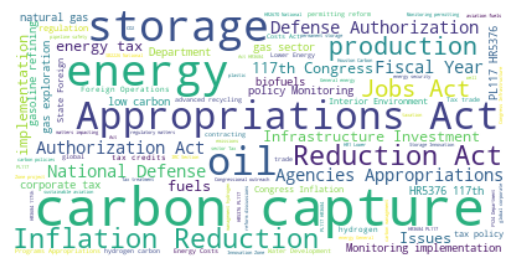

In [834]:
from wordcloud import WordCloud

word_cloud = WordCloud(background_color="white")
word_cloud.generate(" ".join(xom_word_cloud))
import os
from PIL import Image
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [771]:
df[
    [
        "lobbyist_registrant_name",
        "client_name",
        "who_is_lobbying",
        "general_issue_code",
        "description",
    ]
]

,lobbyist_registrant_name,client_name,who_is_lobbying,general_issue_code,description
3570,"HLP&R ADVOCACY, LLC",EXXON MOBIL CORPORATION,hired lobbying firm,TRA,Transportation issues impacting the oil and ga...
3571,"HLP&R ADVOCACY, LLC",EXXON MOBIL CORPORATION,hired lobbying firm,TRD,"Tax, trade and regulatory matters impacting th..."
3572,"HLP&R ADVOCACY, LLC",EXXON MOBIL CORPORATION,hired lobbying firm,TAX,"Tax, trade and regulatory matters impacting th..."
3573,CAPITOL COUNSEL LLC,EXXONMOBIL CORPORATION,hired lobbying firm,FOR,General issues related to foreign policy measu...
3574,CAPITOL COUNSEL LLC,EXXONMOBIL CORPORATION,hired lobbying firm,TAX,"Issues related to tax reform, energy taxes and..."
...,...,...,...,...,...
4382,"THE SIMMONS & RUSSELL GROUP, LLC",EXXONMOBIL CORPORATION,hired lobbying firm,TAX,Discussions related to tax policy. Monitoring ...
4383,"THE SIMMONS & RUSSELL GROUP, LLC",EXXONMOBIL CORPORATION,hired lobbying firm,ENG,Discussions related to energy policy in the gl...
4384,"THE SIMMONS & RUSSELL GROUP, LLC",EXXONMOBIL CORPORATION,hired lobbying firm,TAX,Discussions related to tax policy. Monitoring ...
4385,"THE SIMMONS & RUSSELL GROUP, LLC",EXXONMOBIL CORPORATION,hired lobbying firm,ENG,Discussions related to energy policy in the gl...


In [713]:
query_congress = f"https://api.congress.gov/v3/bill/118/hr/1262/summaries?format=json&api_key={data_gov_api_key}"
s = requests.get(query_congress)
s.json()["summaries"][-1]["text"]

' <p> <strong>CCU Parity Act of 2023 </strong></p> This bill increases the tax credit for carbon capture and use to match incentives for carbon capture and sequestration for both direct air capture and the power and industrial sectors.'

In [582]:
def parse_dollars_spent(income, expense):
    if (income is None) & (expense is None):
        return "income and expense are none", 0.0
    if income is None:
        return "corporation lobbying for itself", float(expense)
    if expense is None:
        return "hired lobbying firm", float(income)
    else:
        return "both income and expense > $0", float(income) + float(expense)


def initialize_row(entity_df, result, filing_id):
    # set up row dictionary using entity booleans
    initialize_row_dict = dict(
        zip(
            [x.lower() for x in list(entity_df["name"])],
            [0] * len(list(entity_df["name"])),
        )
    )
    (
        initialize_row_dict["who_is_lobbying"],
        initialize_row_dict["dollars_spent_lobbying"],
    ) = parse_dollars_spent(result["income"], result["expenses"])
    initialize_row_dict["filing_id"] = filing_id
    initialize_row_dict["url"] = result["url"]
    initialize_row_dict["filing_year"] = int(result["filing_year"])
    initialize_row_dict["filing_period"] = result["filing_period"]
    initialize_row_dict["lobbyist_posted_by_name"] = result["posted_by_name"]

    initialize_row_dict["lobbyist_registrant_id"] = result["registrant"]["id"]
    initialize_row_dict["lobbyist_registrant_name"] = result["registrant"]["name"]
    initialize_row_dict["lobbyist_registrant_contact"] = result["registrant"][
        "contact_name"
    ]
    initialize_row_dict["client_id"] = result["client"]["id"]
    initialize_row_dict["client_client_id"] = result["client"]["client_id"]
    initialize_row_dict["client_name"] = result["client"]["name"]
    initialize_row_dict["affiliated_organizations_present"] = False
    if len(result["affiliated_organizations"]) > 0:
        initialize_row_dict["affiliated_organizations_present"] = True
    initialize_row_dict["convictions_present"] = False
    if len(result["conviction_disclosures"]) > 0:
        initialize_row_dict["convictions_present"] = True
    return initialize_row_dict

In [601]:
def parse_lobbyists(df, lobbyists, details):
    lobby_dict = {}
    lobby_dict["firm_name"] = details["lobbyist_registrant_name"]
    lobby_dict["client_name"] = details["client_name"]
    lobby_dict["general_issue_code"] = details["general_issue_code"]
    lobby_dict["description"] = details["description"]
    lobby_dict["filing_period"] = details["filing_period"]
    lobby_dict["filing_year"] = details["filing_year"]
    lobby_dict["url"] = details["url"]
    lobby_dict["filing_id"] = details["filing_id"]

    lobby_list = []
    # unpack lobbyists list
    for lobbyist in lobbyists:
        lobby_dict["name"] = (
            lobbyist["lobbyist"]["last_name"]
            + ", "
            + lobbyist["lobbyist"]["first_name"]
        )
        lobby_dict["covered_position"] = "None"
        if "covered_position" in lobbyist:
            lobby_dict["covered_position"] = lobbyist["covered_position"]
        lobby_dict["id"] = lobbyist["lobbyist"]["id"]
        lobby_list.append(lobby_dict.copy())

    if df is None:
        df = pd.DataFrame(
            columns=[
                "name",
                "firm_name",
                "client_name",
                "general_issue_code",
                "description",
                "covered_position",
                "filing_year",
                "filing_period",
                "url",
            ]
        )

    df = pd.concat([df, pd.DataFrame(lobby_list)])
    return df

In [882]:
# get govt entity names
entity_df = pd.DataFrame(government_entities)

corporations = [
    "Exxon",
    "ExxonMobil",
]  # 'exxon' alone includes ExxonMobil Exxon Mobil Corp, Exxon Mobil Corporation, etc. ['Exxon Mobil'.upper(),'ExxonMobil'.upper(),'Exxon'

row_list = (
    []
)  # initialize holder for each row (which corresponds to a single lobbying activity)
max_page = 20

filing_id = 0
lobbyists_df = None
for corporation in corporations:
    for year in list(range(1999, 2025)):
        page = 1
        while page < max_page:
            # print(f"Querying page {page} for year {year}")
            query_filings = f'https://lda.senate.gov/api/v1/filings/?client_name="{corporation}"&filing_period=year_end&filing_year={year}&page={page}'

            f = requests.get(query_filings)

            if "detail" in f.json():
                break

            results = f.json()["results"]
            page += 1  # increase the page for the next query
            # print(f"{len(results)} filings found")
            if len(results) < 25:
                page = max_page

            for result in results:
                row_dict_base = initialize_row(entity_df, result, filing_id)
                activities = result["lobbying_activities"]

                for activity_count, activity in enumerate(activities):
                    row_dict = row_dict_base.copy()
                    # set up row dictionary using entity booleans
                    row_dict["activity_count"] = activity_count
                    row_dict["general_issue_code"] = activity["general_issue_code"]
                    row_dict["description"] = activity["description"]
                    lobbyists_df = parse_lobbyists(
                        lobbyists_df, activity["lobbyists"], row_dict
                    )

                    lobbyist_id_list = []
                    for lobbyist in activity["lobbyists"]:
                        lobbyist_id_list.append(lobbyist["lobbyist"]["id"])

                    row_dict["lobbyist_ids"] = "; ".join(
                        ["None" if x is None else str(x) for x in lobbyist_id_list]
                    )
                    for entity in activity["government_entities"]:
                        row_dict[entity["name"].lower()] = 1

                    row_list.append(row_dict.copy())

                    row_dict.clear()
                filing_id += 1

tmp = pd.DataFrame(row_list)
entities_influenced = tmp[[x.lower() for x in list(entity_df["name"])]].sum()
zeroed = list(entities_influenced[entities_influenced == 0].index)
xom_df = tmp[[x for x in tmp.columns.values if x not in zeroed]]
xom_df = xom_df.drop_duplicates(subset=xom_df.columns.difference(["filing_id"]))
xom_unique_filing_ids = list(
    xom_df.filing_id.unique()
)  # keep a list of the non-duplicate filing ids

# keep only right company aliases
company_aliases = [
    "EXXON MOBIL CORP",
    "EXXONMOBIL CHEMICAL CO",
    "EXXON USA",
    "EXXON CO USA",
    "EXXON MOBIL CORPORATION",
    "EXXON MOBIL PRODUCTION CO",
    "EXXON MOBIL",
    "EXXONMOBIL CORPORATION",
    "EXXONMOBIL CORP",
    "EXXON MOBILE",
    "EXXONMOBIL GLOBAL SERVICES COMPANY",
    "DCI GROUP, LLC, ON BEHALF OF EXXONMOBIL",
    "EXXONMOBIL",
    "HUNTON ANDREWS KURTH LLP (FORMERLY HUNTON & WILLIAMS LLP BEHALF OF EXXON MOBIL)",
    "EXXON MOBIL COPORATION",
    "EXXON MOBIL CORP.",
]
xom_df = xom_df.loc[xom_df.client_name.isin(company_aliases)]


lobbyists_df = lobbyists_df.loc[
    (lobbyists_df.client_name.isin(company_aliases))
    & (lobbyists_df.filing_id.isin(xom_unique_filing_ids))
]

xom_df["which_congress"] = [which_congress(y) for y in xom_df["filing_year"]]

In [760]:
test_df[["which_congress", "description"]].loc[
    [x != "" for x in test_df.description]
].to_clipboard()

In [606]:
# how much money has exxonmobil spent lobbying congress in 25 years?
xom_df[["dollars_spent_lobbying", "filing_id"]].groupby("filing_id").first()[
    "dollars_spent_lobbying"
].sum()

340086642.0

In [605]:
xom_df.to_csv("xom_lda_filings.csv")
lobbyists_df.to_csv("xom_lobbyists.csv")

In [612]:
tmp = (
    xom_df[
        [
            "dollars_spent_lobbying",
            "lobbyist_registrant_name",
            "filing_id",
            "filing_year",
        ]
    ]
    .groupby(["lobbyist_registrant_name", "filing_id"])
    .first()
    .reset_index()
)

In [613]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lobbyist_registrant_name  1053 non-null   object 
 1   filing_id                 1053 non-null   int64  
 2   dollars_spent_lobbying    1053 non-null   float64
 3   filing_year               1053 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 33.0+ KB


In [618]:
total_dollars_spent_df = (
    tmp.groupby("lobbyist_registrant_name")
    .agg(
        {
            "dollars_spent_lobbying": "sum",
            "filing_id": "count",
            "filing_year": "min",
            "filing_year": "min",
        }
    )
    .sort_values(by="dollars_spent_lobbying", ascending=False)
)
total_dollars_spent_df.columns = [
    "dollars_spent_lobbying",
    "total_lda_filings",
    "earliest_filing_year",
]
max_year_df = (
    tmp[["lobbyist_registrant_name", "filing_year"]]
    .groupby("lobbyist_registrant_name")
    .agg({"filing_year": "max"})
)
max_year_df.columns = ["latest_filing_year"]
total_dollars_spent_df = total_dollars_spent_df.merge(
    max_year_df, right_index=True, left_index=True
)
total_dollars_spent_df

,dollars_spent_lobbying,total_lda_filings,earliest_filing_year,latest_filing_year
lobbyist_registrant_name,,,,
EXXON MOBIL CORP,304096942.0,88,1999,2024
"DCI GROUP, L.L.C.",3930000.0,53,2005,2016
KELLEY DRYE & WARREN LLP,3360000.0,69,2007,2024
"THE NICKLES GROUP, LLC",3254500.0,54,2006,2019
"ML STRATEGIES, LLC",2355000.0,45,2006,2017
MICHAEL SOLON-CAPITOL LEGISTICS,2235200.0,62,2007,2022
ERNST & YOUNG LLP (WASHINGTON COUNCIL ERNST & YOUNG),2130000.0,64,2007,2022
AVENUE SOLUTIONS,1870000.0,59,2008,2023
BINGHAM MCCUTCHEN LLP,1820000.0,22,2006,2011


In [458]:
xom_dci_lobbyists = list(
    lobbyists_df.loc[lobbyists_df.firm_name == "DCI GROUP, L.L.C."].name.unique()
)

In [426]:
counts_df = (
    lobbyists_df[["name", "firm_name"]]
    .groupby("firm_name")
    .count()
    .sort_values(by="name")
)
counts_df.columns = ["firm_total_filings"]
df = lobbyists_df.merge(counts_df, left_on="firm_name", right_index=True)
counts_df = (
    lobbyists_df[["name", "firm_name"]]
    .groupby("name")
    .count()
    .sort_values(by="firm_name")
)
counts_df.columns = ["total_number_of_filings"]
df = df.merge(counts_df, left_on="name", right_index=True)

,name
firm_name,
WILLIAM HILLEARY,1
"THOMAS ADVISORS, INC",4
"OMB PROFESSIONALS, INC.",6
SOLUTIONS CONSULTING,7
"VALIS ASSOCIATES, LLC",8
"CASSIDY & ASSOCIATES, INC.",9
KERRY CAMMACK,10
CLARK & WEINSTOCK,10
MILLER & CHEVALIER CHARTERED,14


In [431]:
lobbyists_df[["name", "firm_name", "client_name", "total_number_of_filings"]].groupby(
    "name"
).first().sort_values(by="total_number_of_filings", ascending=False).head(50)

,firm_name,client_name,total_number_of_filings
name,,,
"MITCHELL, JEANNE",EXXON MOBIL CORP,EXXON MOBIL CORP,824
"RUSSELL, ROBERT",THE INGRAM GROUP LLC,EXXONMOBIL CORPORATION,390
"SIMMONS, KYLE",THE INGRAM GROUP LLC,EXXONMOBIL CORPORATION,390
"HAINES, R",EXXON MOBIL CORP,EXXON MOBIL CORP,306
"KARDON, JOSH",CAPITOL HILL CONSULTING GROUP,EXXONMOBIL,290
"BUCHHOLTZ, W",EXXON MOBIL CORP,EXXON MOBIL CORP,288
"HAMMER, A",EXXON MOBIL CORP,EXXON MOBIL CORP,283
"WOOD, DANA",KELLEY DRYE & WARREN LLP,EXXON MOBIL CORPORATION,271
"FARIELLO, THERESA",EXXON MOBIL CORP,EXXON MOBIL CORP,257


In [459]:
lob1 = requests.get(
    'https://lda.senate.gov/api/v1/lobbyists/?registrant_name="DCI GROUP, L.L.C."&page=1'
)
lob2 = requests.get(
    'https://lda.senate.gov/api/v1/lobbyists/?registrant_name="DCI GROUP, L.L.C."&page=2'
)
dci_lobbyists = lob1.json()["results"] + lob2.json()["results"]

In [462]:
all_dci_lobbyists = []
for dci in dci_lobbyists:
    all_dci_lobbyists.append(dci["last_name"] + ", " + dci["first_name"])

sorted(all_dci_lobbyists)

['ARCENEAUX, ALYSSA',
 'BASYE, GEOFFREY',
 'BENTZEL, CARL',
 'BIRKHOFER, MATT',
 'BORLAND, KEVIN',
 'CAOL, DREW',
 'CHIANCHETTE, PETER',
 'CLINGHAM, GAVIN',
 'COLE, DREW',
 'CRADDOCK, FRANK',
 'DAVENPORT, DOUG',
 'ENYON, TEDDY',
 'FEATHER, TONY',
 'FLOOD, ANGELA',
 'FRICKS, JOSEPH',
 'FRITZ, TRISH',
 'GRILLO, RYAN',
 'HORRELL, CHAD',
 'KENNEDY, BRIAN',
 'LACIVITA, CHRIS',
 'LARSON, CHRIS',
 'LAWRENCE, LINDSAY',
 'LEGER, STEPHANIE',
 'MATRICARDI, ED',
 'MCCABE, BRIAN',
 'MCCULLOUGH, CATHERINE',
 'MCKENNA, ANDREW',
 'OLSON, GRANT',
 'OSCHAL, JENNIFER',
 'PEARCE, DAVID',
 'PETERSON, JUSTIN',
 'RICHARDSON, CRAIG',
 'RYAN, PAUL',
 'SHOCKEY, ALEX',
 'STRATTON, HAL',
 'SYNHORST, TOM',
 'TOBIN, JAMES',
 'TOOZE, COLIN',
 'TURNER, JONA',
 'VIDENIEKS, LINDSAY',
 'WHITAKER, STEPHEN',
 'WILKINSON, SCOTT',
 'WOLF, OLIVER',
 'ZIEBART, GEOFFREY']

In [ ]:
xom_df.loc[xom_df.f]

In [463]:
xom_dci_lobbyists

['BIRKHOFER, MATT',
 'BENTZEL, CARL',
 'COLE, DREW',
 'CRADDOCK, FRANK',
 'PEARCE, DAVID',
 'FLOOD, ANGELA']

In [129]:
xom_dict={}
for x in xom:
    xom_dict['year']=int(x['filing_year'])
    xom_dict['rest']=

{'url': 'https://lda.senate.gov/api/v1/filings/ae63a422-c47c-4ed0-9099-fa11613cbd6d/',
 'filing_uuid': 'ae63a422-c47c-4ed0-9099-fa11613cbd6d',
 'filing_type': 'YY',
 'filing_type_display': 'Year-End Report',
 'filing_year': 2000,
 'filing_period': 'year_end',
 'filing_period_display': 'Year-End (July 1 - Dec 31)',
 'filing_document_url': 'https://lda.senate.gov/filings/public/filing/ae63a422-c47c-4ed0-9099-fa11613cbd6d/print/',
 'filing_document_content_type': 'application/pdf',
 'income': '0.00',
 'expenses': None,
 'expenses_method': None,
 'expenses_method_display': None,
 'posted_by_name': None,
 'dt_posted': '1940-02-21T00:00:00-05:00',
 'termination_date': None,
 'registrant_country': 'United States of America',
 'registrant_ppb_country': 'United States of America',
 'registrant_address_1': None,
 'registrant_address_2': None,
 'registrant_different_address': None,
 'registrant_city': None,
 'registrant_state': None,
 'registrant_zip': None,
 'registrant': {'id': 39837,
  'url': 

In [433]:
lob = requests.get("https://lda.senate.gov/api/v1/lobbyists/")
filing_types = requests.get(
    "https://lda.senate.gov/api/v1/constants/filing/filingtypes/"
)
general_issues = requests.get(
    "https://lda.senate.gov/api/v1/constants/filing/lobbyingactivityissues/"
)
govt_entities = requests.get(
    "https://lda.senate.gov/api/v1/constants/filing/governmententities/"
)
countries = requests.get("https://lda.senate.gov/api/v1/constants/general/countries/")
states = requests.get("https://lda.senate.gov/api/v1/constants/general/states/")
prefixes = requests.get("https://lda.senate.gov/api/v1/constants/lobbyist/prefixes/")
suffixes = requests.get("https://lda.senate.gov/api/v1/constants/lobbyist/suffixes/")
contribution_items = requests.get(
    "https://lda.senate.gov/api/v1/constants/contribution/itemtypes/"
)

In [453]:
lob = requests.get(
    'https://lda.senate.gov/api/v1/lobbyists/?registrant_name="DCI GROUP, L.L.C."&page=2'
)
lob.json()["results"]

[{'id': 35116,
  'prefix': None,
  'prefix_display': None,
  'first_name': 'BRIAN',
  'nickname': None,
  'middle_name': None,
  'last_name': 'KENNEDY',
  'suffix': None,
  'suffix_display': None,
  'registrant': {'id': 61174,
   'url': 'https://lda.senate.gov/api/v1/registrants/61174/',
   'house_registrant_id': 36371,
   'name': 'DCI GROUP, L.L.C.',
   'description': 'Public affairs',
   'address_1': '2000 K Street, NW',
   'address_2': '9th Floor',
   'address_3': None,
   'address_4': None,
   'city': 'Washington',
   'state': 'DC',
   'state_display': 'District of Columbia',
   'zip': '20006',
   'country': 'US',
   'country_display': 'United States of America',
   'ppb_country': 'US',
   'ppb_country_display': 'United States of America',
   'contact_name': 'REBECCA NEVILLE',
   'contact_telephone': '+1 202-777-1566',
   'dt_updated': '2024-07-25T09:38:49.084179-04:00'}},
 {'id': 35673,
  'prefix': None,
  'prefix_display': None,
  'first_name': 'KEVIN',
  'nickname': None,
  'mid

In [484]:
contributions = []
for page in range(1, 4):
    c = requests.get(
        f'https://lda.senate.gov/api/v1/contributions/?registrant_name="DCI GROUP, L.L.C."&filing_type=YY&page={page}'
    )
    contributions = contributions + c.json()["results"]

In [494]:
row_list = []

for dci in contributions:
    row_dict = {}
    for i in dci["contribution_items"]:
        row_dict["contribution_type"] = i["contribution_type"]
        row_dict["contributor_name"] = i["contributor_name"]
        row_dict["payee_name"] = i["payee_name"]
        row_dict["honoree_name"] = i["honoree_name"]
        row_dict["usd"] = float(i["amount"])
        row_dict["date"] = i["date"]
        row_dict["filing_year"] = dci["filing_year"]
        row_dict["registrant_name"] = dci["registrant"]["name"]
        row_list.append(row_dict.copy())
dci_contributions_df = pd.DataFrame(row_list)

In [532]:
def strip_terms(x, terms):
    for term in terms:
        x = x.replace(term, "")

    return x.split(" (")[0].title()

In [535]:
terms = [
    "Senator ",
    "US ",
    "Rep. ",
    "U.S. ",
    "Representative ",
    "Sen. ",
    "Congressional ",
    "Candidate ",
    "Congressman ",
    "for ",
    "Friends of ",
]

print(dci_contributions_df.honoree_name.nunique())
print(dci_contributions_df.stripped_honoree_name.nunique())

281
181


In [534]:
dci_contributions_df.honoree_name.unique()
terms = [
    "Senator ",
    "US ",
    "Rep. ",
    "Congresswoman ",
    "U.S. ",
    " 08",
    " Jr.",
    "Jr",
    "Resident Commissioner of Puerto Rico ",
    "Senate ",
    "Campaign",
    "Presidential ",
    "candidate ",
    "Candidate ",
    "Representative ",
    "Sen. ",
    "House ",
    "Congressional ",
    "Candidate ",
    "Representative-Elect ",
    "Campaign Committee",
    "Committee",
    "Congressman ",
    "for ",
    "Friends of ",
    " Senate",
    " Congress",
    "Friend of ",
    "- In-Kind Donation",
]
dci_contributions_df["stripped_honoree_name"] = [
    strip_terms(x, terms) for x in dci_contributions_df.honoree_name
]
dci_contributions_df.stripped_honoree_name.unique()

array(['Paul Carmouche', 'Mark Pryor', 'Parker Griffith', 'Alan Mollohan',
       'Democratic  ', 'Gordon Smith', 'Mike Johanns', 'Mitch Mcconnell',
       'Lamar Alexander', 'John Salazar', 'Peter Defazio', 'Mark Souder',
       'The Freedom Project', 'Mccain ', 'John Boehner', 'Mcconnell ',
       'Dci Group Pac', 'Ann Barth', 'Souder', 'Allan Mollohan',
       'Alexander', 'Defazio', 'Johanns', 'Gordan Smith',
       'Kirsten Gillibrand', 'Charlie Melancon', 'Jim Oberstar',
       'Portman', 'Gillibrand', 'Castillo', 'Jim Clyburn',
       'Kendrick Meek Florida', 'Georgians Isakson', 'Charlie Melancon  ',
       'Boyd', 'Pete King', 'James Oberstar', 'Kendrick Meek',
       'Allen Boyd', 'Kirsten Gillibrand ', 'David Castillo',
       'James Clyburn', 'Johnny Isakson', 'Rob Portman', 'Peter King',
       'Chad Causey', 'Nrcc', 'Kelly Ayotte', 'Bill Flores',
       'Mary Landrieu', 'N/A', 'Connie Mack', 'Roy Blunt', 'Eric Cantor',
       'John Dingell', 'Chris Coons', 'Karen Diebel',

In [570]:
yy = list(dci_contributions_df.stripped_honoree_name.unique())
dci_contributions_df["stripped_honoree_name"] = [
    x.strip() for x in dci_contributions_df["stripped_honoree_name"]
]
dci_contributions_df["stripped_honoree_name_sim"] = dci_contributions_df[
    "stripped_honoree_name"
]
for y in yy:
    dci_contributions_df["stripped_honoree_name_sim"] = [
        y if x in y else x for x in dci_contributions_df.stripped_honoree_name_sim
    ]
yy = list(dci_contributions_df.stripped_honoree_name_sim.unique())
for y in yy:
    dci_contributions_df["stripped_honoree_name_sim"] = [
        y if x in y else x for x in dci_contributions_df.stripped_honoree_name_sim
    ]

In [573]:
yy = list(dci_contributions_df.stripped_honoree_name_sim.unique())
for term, replacement in {
    "Allan": "Alan",
    "Jim": "James",
    "Gordan": "Gordon",
    "&": "And",
    "Georgians": "Johnny",
    "M.": "Mary",
    "Pete": "Peter",
}.items():
    dci_contributions_df["stripped_honoree_name_sim"] = [
        x.replace(term, replacement)
        for x in dci_contributions_df.stripped_honoree_name_sim
    ]

In [578]:
dci_contributions_df[["stripped_honoree_name_sim", "usd"]].groupby(
    "stripped_honoree_name_sim"
).sum().sort_values(by="usd", ascending=False).sum()

usd    421845.57
dtype: float64

In [556]:
import pandas as pd
from name_matching.name_matcher import NameMatcher

# define a dataset with bank names
df_a = pd.DataFrame({"recipient1": y})

# alter each of the bank names a bit to test the matching
df_b = pd.DataFrame({"recipient2": sorted(y)})

# initialise the name matcher
matcher = NameMatcher(
    number_of_matches=5, legal_suffixes=True, common_words=False, top_n=50, verbose=True
)

# adjust the distance metrics to use
matcher.set_distance_metrics(["bag", "typo", "refined_soundex"])

# load the data to which the names should be matched
matcher.load_and_process_master_data(
    column="recipient1", df_matching_data=df_a, transform=True
)

# perform the name matching on the data you want matched
matches = matcher.match_names(to_be_matched=df_b, column_matching="recipient2")

# combine the datasets based on the matches
# combined = pd.merge(df_a, matches, how='left', left_index=True, right_on='match_index')
# combined#combined = pd.merge(combined, df_b, how='left', left_index=True, right_index=True)

preprocessing...

preprocessing complete 
 searching for matches...



100%|██████████| 1/1 [00:00<00:00, 451.19it/s]


possible matches found   
 fuzzy matching...



100%|██████████| 181/181 [00:04<00:00, 44.35it/s]

done


In [557]:
# matches.drop(['match_name_0','score_0'],axis=1,inplace=True)
matches

,original_name,match_name_0,score_0,match_index_0,match_name_1,score_1,match_index_1,match_name_2,score_2,match_index_2,match_name_3,score_3,match_index_3,match_name_4,score_4,match_index_4
0,adrian smith,adrian smith,100.0,178,gordan smith,66.269841,23,gordon smith,62.103175,5,tim scott,46.250100,163,cedric richmond,45.311463,114
1,alan mollohan,alan mollohan,100.0,3,allan mollohan,95.238095,19,allen boyd,46.620426,38,salmon,44.056323,123,charlie melancon,42.293390,25
2,alexander,alexander,100.0,20,lamar alexander,60.833333,8,landrieu,55.555556,68,m landrieu,50.841510,92,altmire,47.381086,88
3,allan mollohan,allan mollohan,100.0,19,alan mollohan,95.238095,3,allen boyd,49.480871,38,charlie melancon,42.903584,25,charlie melancon,42.903584,33
4,allen boyd,allen boyd,100.0,38,allan mollohan,49.480871,19,alan mollohan,46.620426,3,kelly ayotte,43.233145,47,alexander,39.595599,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,tom graves,tom graves,100.0,140,garret graves,55.165020,149,tom perez,53.916197,173,jim oberstar,42.934543,26,john barrasso,42.756049,73
177,tom perez,tom perez,100.0,173,tom graves,53.916197,140,jim oberstar,46.715879,26,matt mowers,40.238423,171,bob menendez,39.238322,96
178,tommy thompson,tommy thompson,100.0,99,jim matheson,49.923220,102,johnny isakson,42.082998,42,pete olson,41.173555,104,olympia snowe,39.281075,75
179,various,various,100.0,180,barasso,43.650794,83,mark souder,42.121212,11,chris coons,36.060606,55,marco rubio,34.299579,167


In [496]:
dci_contributions_df[["filing_year", "usd"]].groupby("filing_year").sum()

,usd
filing_year,
2008,73100.00
2009,34600.00
2010,49450.00
2011,46500.00
2012,28750.00
2013,61500.00
2014,24039.54
2015,52000.00
2016,19500.00


In [98]:
firms = []
# lobbyists=lobbyists.json()['results']
for lobby in lobbyists:
    print(lobby)
    firms.append(lobby["registrant"]["name"])

{'id': 1, 'prefix': None, 'prefix_display': None, 'first_name': 'ALICE', 'nickname': None, 'middle_name': None, 'last_name': 'DUCQ', 'suffix': None, 'suffix_display': None, 'registrant': {'id': 51968, 'url': 'https://lda.senate.gov/api/v1/registrants/51968/', 'house_registrant_id': 34851, 'name': 'MAYBERRY & ASSOCIATES, LLC', 'description': None, 'address_1': '131 EAST BROAD STREET, #206', 'address_2': None, 'address_3': None, 'address_4': None, 'city': 'FALLS CHURCH', 'state': 'VA', 'state_display': 'Virginia', 'zip': '22046', 'country': 'US', 'country_display': 'United States of America', 'ppb_country': 'US', 'ppb_country_display': 'United States of America', 'contact_name': 'MR. PETER MAYBERRY', 'contact_telephone': '+1 703-538-8804', 'dt_updated': '2022-04-06T16:07:54.085048-04:00'}}
{'id': 2, 'prefix': None, 'prefix_display': None, 'first_name': 'TOBIN', 'nickname': None, 'middle_name': 'L', 'last_name': 'SMITH', 'suffix': None, 'suffix_display': None, 'registrant': {'id': 23964, 

In [95]:
firms

['MAYBERRY & ASSOCIATES, LLC',
 'MASSACHUSETTS INSTITUTE OF TECHNOLOGY',
 'GREENLEE PARTNERS, LLC',
 'KSA CONSULTING',
 'NATIONAL FAIR HOUSING ALLIANCE',
 'WILSON ELSER MOSLOWITZ EDELMAN & DICKER, LLP',
 'AVOQ, LLC (FRA TEAM SUBJECT MATTER, LLC)',
 'GORDLEY ASSOCIATES',
 'MEAT INSTITUTE (FKA NORTH AMERICAN MEAT INSTITUTE)',
 'OPTICAL SOCIETY OF AMERICA',
 'DENNY MILLER ASSOCIATES',
 'AMERICAN FOREST & PAPER ASSOCIATION',
 'PEOPLE FOR THE AMERICAN WAY',
 'CONSUMER TECHNOLOGY ASSOCIATION',
 'MR. ROBERT WILSON',
 'HURT, NORTON & ASSOCIATES, INC.',
 'SOMMER BARNARD PC',
 'NATIONAL ASSOCIATION OF REALTORS',
 'FEMINIST MAJORITY, THE',
 'FRANKLEE SPEAKING LLC',
 'QUINN THOMAS PUBLIC AFFAIRS',
 'BKSH & ASSOCIATES',
 'NATIONAL ASSOCIATION OF HOME BUILDERS',
 'GEORGIA-PACIFIC LLC',
 'CHAMBER OF COMMERCE OF THE U.S.A.']

In [84]:
payee = "Friends of Max Baucus".replace(" ", "%20")
year = "2008"
contributor = "Crossroads Strategies, LLC".replace(" ", "%20")
year = "2023"
query_all_contributions = f"https://lda.senate.gov/api/v1/contributions/?contribution_payee={payee}&filing_year={year}"
c = requests.get(query_all_contributions)
baucus = c.json()["results"]

In [90]:
contributor = "Crossroads Strategies".replace(" ", "%20")
year = "2023"
query_all_contributions = f"https://lda.senate.gov/api/v1/contributions/?contribution_contributor={contributor}&filing_year={year}"
c = requests.get(query_all_contributions)
crossroads = c.json()["results"]

In [91]:
crossroads

[]

In [81]:
total = 0

for cc in baucus:
    contributions = cc["contribution_items"]
    for i in contributions:
        if i["payee_name"].lower() == "friends of max baucus":
            print(f'{i["contributor_name"]}, amount: ${i["amount"]}')
            total = total + float(i["amount"])

In [82]:
total

0

In [45]:
govt_entities_df = pd.DataFrame(govt_entities.json())
contribution_items_df = pd.DataFrame(contribution_items.json())
general_issues_df = pd.DataFrame(general_issues.json())
filing_types_df = pd.DataFrame(filing_types.json())

In [24]:
constants = requests.get("https://lda.senate.gov/api/v1/constants/")
constants.json()

JSONDecodeError: Expecting value: line 3 column 1 (char 2)

In [21]:
r.json()

{'filings': 'https://lda.senate.gov/api/v1/filings/',
 'contributions': 'https://lda.senate.gov/api/v1/contributions/',
 'registrants': 'https://lda.senate.gov/api/v1/registrants/',
 'clients': 'https://lda.senate.gov/api/v1/clients/',
 'lobbyists': 'https://lda.senate.gov/api/v1/lobbyists/',
 'constants/filing/filingtypes': 'https://lda.senate.gov/api/v1/constants/filing/filingtypes/',
 'constants/filing/lobbyingactivityissues': 'https://lda.senate.gov/api/v1/constants/filing/lobbyingactivityissues/',
 'constants/filing/governmententities': 'https://lda.senate.gov/api/v1/constants/filing/governmententities/',
 'constants/general/countries': 'https://lda.senate.gov/api/v1/constants/general/countries/',
 'constants/general/states': 'https://lda.senate.gov/api/v1/constants/general/states/',
 'constants/lobbyist/prefixes': 'https://lda.senate.gov/api/v1/constants/lobbyist/prefixes/',
 'constants/lobbyist/suffixes': 'https://lda.senate.gov/api/v1/constants/lobbyist/suffixes/',
 'constants/

In [17]:
rr = requests.get(r.json()["filings"] + "?client_name=exxon%20mobil&filing_year=2023")

In [19]:
rr.json()

{'count': 34,
 'next': 'https://lda.senate.gov/api/v1/filings/?client_name=exxon+mobil&filing_year=2023&page=2',
 'previous': None,
 'results': [{'url': 'https://lda.senate.gov/api/v1/filings/17a0b97c-5028-489e-b0e3-38bd0f74cd92/',
   'filing_uuid': '17a0b97c-5028-489e-b0e3-38bd0f74cd92',
   'filing_type': 'Q1',
   'filing_type_display': '1st Quarter - Report',
   'filing_year': 2023,
   'filing_period': 'first_quarter',
   'filing_period_display': '1st Quarter (Jan 1 - Mar 31)',
   'filing_document_url': 'https://lda.senate.gov/filings/public/filing/17a0b97c-5028-489e-b0e3-38bd0f74cd92/print/',
   'filing_document_content_type': 'text/html',
   'income': '30000.00',
   'expenses': None,
   'expenses_method': None,
   'expenses_method_display': None,
   'posted_by_name': 'Timothy F. Hannegan',
   'dt_posted': '2023-04-18T07:36:50-04:00',
   'termination_date': None,
   'registrant_country': 'United States of America',
   'registrant_ppb_country': None,
   'registrant_address_1': '701 P

In [16]:
rr.json()["results"][0].keys()

dictionary = rr.json()["results"][0]
dictionary = flatten(dictionary)

for key, value in dictionary.items():
    print(f"{key}: {value}")

url: https://lda.senate.gov/api/v1/filings/7b9b34c8-31b1-4720-80e5-cc68f1d8c5db/
filing_uuid: 7b9b34c8-31b1-4720-80e5-cc68f1d8c5db
filing_type: Q1
filing_type_display: 1st Quarter - Report
filing_year: 2023
filing_period: first_quarter
filing_period_display: 1st Quarter (Jan 1 - Mar 31)
filing_document_url: https://lda.senate.gov/filings/public/filing/7b9b34c8-31b1-4720-80e5-cc68f1d8c5db/print/
filing_document_content_type: text/html
income: 20000.00
expenses: None
expenses_method: None
expenses_method_display: None
posted_by_name: Adina Mincher
dt_posted: 2023-04-13T09:49:37-04:00
termination_date: None
registrant_country: US
registrant_ppb_country: US
registrant_address_1: 300 Tingey Street SE
registrant_address_2: Suite 202
registrant_different_address: False
registrant_city: Washington
registrant_state: DC
registrant_zip: 20003
registrant_id: 70175
registrant_url: https://lda.senate.gov/api/v1/registrants/70175/
registrant_house_registrant_id: 30174
registrant_name: MERCURY PUBLIC 

In [10]:
flatten(dictionary)

{'url': 'https://lda.senate.gov/api/v1/filings/7b9b34c8-31b1-4720-80e5-cc68f1d8c5db/',
 'filing_uuid': '7b9b34c8-31b1-4720-80e5-cc68f1d8c5db',
 'filing_type': 'Q1',
 'filing_type_display': '1st Quarter - Report',
 'filing_year': 2023,
 'filing_period': 'first_quarter',
 'filing_period_display': '1st Quarter (Jan 1 - Mar 31)',
 'filing_document_url': 'https://lda.senate.gov/filings/public/filing/7b9b34c8-31b1-4720-80e5-cc68f1d8c5db/print/',
 'filing_document_content_type': 'text/html',
 'income': '20000.00',
 'expenses': None,
 'expenses_method': None,
 'expenses_method_display': None,
 'posted_by_name': 'Adina Mincher',
 'dt_posted': '2023-04-13T09:49:37-04:00',
 'termination_date': None,
 'registrant_country': 'US',
 'registrant_ppb_country': 'US',
 'registrant_address_1': '300 Tingey Street SE',
 'registrant_address_2': 'Suite 202',
 'registrant_different_address': False,
 'registrant_city': 'Washington',
 'registrant_state': 'DC',
 'registrant_zip': '20003',
 'registrant_id': 70175,

In [ ]:
query = f"https://developer.nrel.gov/api/pvwatts/v8.json?api_key={config['apikey']}&lat={lat}&lon={lon}&system_capacity={config['kw']}&azimuth={azimuth}&tilt={tilt}&array_type=1&module_type=1&losses=10"
                response = requests.get(query, timeout=20)
                info_dict["ac_annual"] = response.json()["outputs"]["ac_annual"]